# Analysis on Drop Validation results
## Drop-trained model (v0)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import re
import os


t5_model = 't5-small'

In [2]:
#choose a version
local_versions = glob.glob('./data/*',recursive=True)
local_versions  = [x for x in local_versions if 'experiments' not in x]
print('versions available locally:')
for x in range(len(local_versions)):
    print(f'{x+1}. {local_versions[x]}')
selection = -1    
while(selection not in range(len(local_versions)+1)):
    selection = input('Enter number: ')
    try:
        selection = int(selection)
    except:
        print('please enter a number')

selection -= 1
version_dir = local_versions[selection]
    
data_dir = f"{version_dir}/{t5_model}"
results_dir = f"{data_dir}/results/"
assert os.path.exists(results_dir), 'error, no results found in folder {}'.format(results_dir)

#choose a results file
files = glob.glob(results_dir+'*.pkl',recursive=True)
for i in range(len(files)):
    print(f'{i+1}. {files[i].rsplit("/",1)[1]}')
selection = -1    
while(selection not in range(len(files)+1)):
    selection = input('Enter number: ')
    try:
        selection = int(selection)
    except:
        print('please enter a number')    
selection -= 1        

print('Importing dataframe of results...')
df = pd.read_pickle(files[selection])
print(f'F1 score: {df.F1.mean():0.5f}')
print(f'EM score: {df.EM.mean():0.5f}')
df.head()

versions available locally:
1. ./data/drop_only-v0
2. ./data/drop_only-v1
3. ./data/processed-data
4. ./data/zeroshot-v0


Enter number:  2


1. drop_validation0155-Jul14.pkl


Enter number:  1


Importing dataframe of results...
F1 score: 0.34810
EM score: 0.30498


,section_id,query_id,passage,question,answers_spans,predicted,EM,F1
0,nfl_1184,f37e81fa-ef7b-4583-b671-762fc433faa9,Hoping to rebound from their loss to the Patr...,Who scored the first touchdown of the game?,"{'spans': ['Chaz Schilens', 'JaMarcus Russell'...",Chaz Schilens,1.0,1.0
1,nfl_1184,ac6ba235-3024-4f63-a6ab-730a14def4cb,Hoping to rebound from their loss to the Patr...,How many field goals did Kris Brown kick?,"{'spans': ['2', '3', '3', '3', '3'], 'types': ...",3,1.0,1.0
2,nfl_1184,2c7c93f6-69ed-47cc-a5af-94a00c185a26,Hoping to rebound from their loss to the Patr...,Which team won the game?,"{'spans': ['Raiders', 'Raiders', 'Raiders', 't...",Texans,0.0,0.0
3,nfl_1184,7dfd2b64-f39e-4bb4-aeb0-1900adda6018,Hoping to rebound from their loss to the Patr...,How many field goals did both teams kick in th...,"{'spans': ['2', '2', '2', '2', '2'], 'types': ...",2,1.0,1.0
4,nfl_1184,121a8f57-7752-4373-a9ba-748b2c577cd2,Hoping to rebound from their loss to the Patr...,How many more yards was Kris Browns's first fi...,"{'spans': ['29', '20', '29', '29', '29'], 'typ...",1,0.0,0.0


In [3]:
def print_example(query_id,df):
    print('question: ',df.loc[df.query_id == query_id,'question'].iloc[0])
    print('passage: ',df.loc[df.query_id == query_id,'passage'].iloc[0])
    print('\npredicted answer: ',df.loc[df.query_id == query_id,'predicted'].iloc[0])
    print('True answers: ',df.loc[df.query_id == query_id,'answers_spans'].iloc[0])
    print('F1 score: ',df.loc[df.query_id == query_id,'F1'].iloc[0])
    print('EM score: ',df.loc[df.query_id == query_id,'EM'].iloc[0])
    
    
query_id = '0686d1f9-4a8e-4031-b665-49d425afb777'
print_example(query_id,df)

question:  What kind of people were on the ships that arrived at St. Croix in August?
passage:  Danish officials appealed for help to French colonists at Martinique, located 324 miles away. Two French ships arrived from there to St. John on April 23, 1734, carrying several hundred French and Swiss troops to try to take control from the rebels. With their firepower and troops, by mid-May they had restored planters' rule of the island. The French ships returned to Martinique on June 1, leaving the local militia to track down the remaining rebels, which they did over the next three months. The slave insurrection was considered ended on August 25, 1734 when Sergeant Øttingen captured the remaining maroon rebels. The loss of life and property from the insurrection caused many St. John landowners to move to St. Croix, a nearby island bought by the Danish from the French in 1733. Four ships carried planters and their families from Charlotte Amalie in August. While they found St. Croix to be a

In [4]:
query_id = '86dd1721-6bf4-45fa-b01e-de47e4f7301d'
print_example(query_id,df)

question:  How many percent are not Marriage couples living together?
passage:  There were 664,594 households out of which 24.35% had children under the age of 18 living with them, 46.28% were Marriage living together, 11.68% had a female householder with no husband present, and 37.40% were non-families. 30.11% of all households were made up of individuals and 14.70% (4.02% male and 10.68% female) had someone living alone who was 65 years of age or older. The average household size was 2.39 and the average family size was 2.97.

predicted answer:  53.82
True answers:  {'spans': array(['53.72', '46.28', '53.72', '37.4'], dtype=object), 'types': array(['number', 'number', 'number', 'number'], dtype=object)}
F1 score:  0.0
EM score:  0.0


In [5]:
query_id = 'ad19857f-cd76-4d01-ba29-1a589cfee053'
print_example(query_id,df)

question:  How many rushing touchdowns occurred in the game?
passage:   The Eagles faced off with the Baltimore Ravens in an interconference matchup.  Both defenses dominated the first quarter, and in the second quarter, Baltimore forced three turnovers (two interceptions and a fumble) from Donovan McNabb.  Ravens kicker Matt Stover booted a 44-yard field goal, while quarterback Joe Flacco completed a 1-yard touchdown pass to tight end Daniel Wilcox.  However, rookie  Quintin Demps returned the following kickoff 100 yards for a Philadelphia touchdown to make it 10-7 Ravens at halftime.  Andy Reid decided to bench McNabb (who was 8-for-18 for 59 yards and two interceptions) and put backup quarterback Kevin Kolb into the game.  Kolb also struggled with the Baltimore defense, and the Eagles fell behind 12-7 when linebacker Jameel McClain blocked Sav Rocca's punt into the back of the endzone for a safety. In the fourth, the Ravens kicked another field goal after a Kolb interception, then M

In [7]:
df.head()

,section_id,query_id,passage,question,answers_spans,predicted,EM,F1,Or,Sort,Math,Who,What,When,Where,Why,How,Which,Boolean
0,nfl_1184,f37e81fa-ef7b-4583-b671-762fc433faa9,Hoping to rebound from their loss to the Patr...,Who scored the first touchdown of the game?,"{'spans': ['Chaz Schilens', 'JaMarcus Russell'...",Chaz Schilens,1.0,1.0,0,1,0,0,0,0,0,0,0,0,0
1,nfl_1184,ac6ba235-3024-4f63-a6ab-730a14def4cb,Hoping to rebound from their loss to the Patr...,How many field goals did Kris Brown kick?,"{'spans': ['2', '3', '3', '3', '3'], 'types': ...",3,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0
2,nfl_1184,2c7c93f6-69ed-47cc-a5af-94a00c185a26,Hoping to rebound from their loss to the Patr...,Which team won the game?,"{'spans': ['Raiders', 'Raiders', 'Raiders', 't...",Texans,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0
3,nfl_1184,7dfd2b64-f39e-4bb4-aeb0-1900adda6018,Hoping to rebound from their loss to the Patr...,How many field goals did both teams kick in th...,"{'spans': ['2', '2', '2', '2', '2'], 'types': ...",2,1.0,1.0,0,1,0,0,0,0,0,0,0,0,0
4,nfl_1184,121a8f57-7752-4373-a9ba-748b2c577cd2,Hoping to rebound from their loss to the Patr...,How many more yards was Kris Browns's first fi...,"{'spans': ['29', '20', '29', '29', '29'], 'typ...",1,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0


In [7]:
df.iloc[0]['answers_spans']['spans'][0]

'Chaz Schilens'

In [8]:
# create answer type column
df['answer_type'] = df.answers_spans.apply(lambda d: d['types'][0])
df.answer_type.value_counts()

number    5889
span      3503
date       143
Name: answer_type, dtype: int64

In [9]:
##### import re
def tag_questions(df):
    #tag columns
    question_labels = ['Or','Sort','Math','Who','What','When','Where','Why','How','Which','Boolean']
    for label in question_labels:
        df[label] = 0

    df.reset_index(drop=True, inplace = True) #clean up - adding indicies

    #or
    ind = df[df['question'].str.contains(" or ", flags=re.IGNORECASE)].index
    for i in ind:
        df.at[i, 'Or'] = 1
    
    sort_keywords = ["est","first","last","more","less","better","worse",]

    #sort
    a = df[df['question'].str.contains("est", flags=re.IGNORECASE)].index
    b = df[df['question'].str.contains("first", flags=re.IGNORECASE)].index
    c = df[df['question'].str.contains("last", flags=re.IGNORECASE)].index
    d = df[df['question'].str.contains("more", flags=re.IGNORECASE)].index
    e = df[df['question'].str.contains("less", flags=re.IGNORECASE)].index
    f = df[df['question'].str.contains("better", flags=re.IGNORECASE)].index
    g = df[df['question'].str.contains("worse", flags=re.IGNORECASE)].index
    ind = [*a, *b, *c, *d, *e, *f, *g]
    for i in ind:
        df.at[i, 'Sort'] = 1

    #math
    n = df[df['answer_type'] == 'number'].index
    for i in n:
        ans = df.iloc[i]['answers_spans']['spans'][0]
        #passage = df.iloc[i]['passage']
        if df.iloc[i]['passage'].find(ans) == False:
            df.at[i, 'Math'] = 1                                     

    #W tags
    ind = df[df['question'].str.startswith("Who")].index
    for i in ind:
        df.at[i, 'Who'] = 1
    ind = df[df['question'].str.startswith("What")].index
    for i in ind:
        df.at[i, 'What'] = 1
    ind = df[df['question'].str.startswith("When")].index
    for i in ind:
        df.at[i, 'When'] = 1
    ind = df[df['question'].str.startswith("Where")].index
    for i in ind:
        df.at[i, 'Where'] = 1
    ind = df[df['question'].str.startswith("Why")].index
    for i in ind:
        df.at[i, 'Why'] = 1
    ind = df[df['question'].str.startswith("How")].index
    for i in ind:
        df.at[i, 'How'] = 1
    ind = df[df['question'].str.startswith("Which")].index
    for i in ind:
        df.at[i, 'Which'] = 1
    a = df[df['question'].str.startswith("Is")].index
    b = df[df['question'].str.startswith("Was")].index
    ind = [*a, *b]
    for i in ind:
        df.at[i, 'Boolean'] = 1
    return df
#df_span = df[df['answer_type'] == 'span' | df['answer_type'] == 'spans']
#df_date = df[df['answer_type'] == 'date']
#df_num = df[df['answer_type'] == 'number']

df = tag_questions(df)
df.head()

,section_id,query_id,passage,question,answers_spans,predicted,EM,F1,Or,Sort,Math,Who,What,When,Where,Why,How,Which,Boolean,answer_type
0,nfl_1184,f37e81fa-ef7b-4583-b671-762fc433faa9,Hoping to rebound from their loss to the Patr...,Who scored the first touchdown of the game?,"{'spans': ['Chaz Schilens', 'JaMarcus Russell'...",Chaz Schilens,1.0,1.0,0,1,0,1,0,0,0,0,0,0,0,span
1,nfl_1184,ac6ba235-3024-4f63-a6ab-730a14def4cb,Hoping to rebound from their loss to the Patr...,How many field goals did Kris Brown kick?,"{'spans': ['2', '3', '3', '3', '3'], 'types': ...",3,1.0,1.0,0,0,0,0,0,0,0,0,1,0,0,number
2,nfl_1184,2c7c93f6-69ed-47cc-a5af-94a00c185a26,Hoping to rebound from their loss to the Patr...,Which team won the game?,"{'spans': ['Raiders', 'Raiders', 'Raiders', 't...",Texans,0.0,0.0,0,0,0,0,0,0,0,0,0,1,0,span
3,nfl_1184,7dfd2b64-f39e-4bb4-aeb0-1900adda6018,Hoping to rebound from their loss to the Patr...,How many field goals did both teams kick in th...,"{'spans': ['2', '2', '2', '2', '2'], 'types': ...",2,1.0,1.0,0,1,0,0,0,0,0,0,1,0,0,number
4,nfl_1184,121a8f57-7752-4373-a9ba-748b2c577cd2,Hoping to rebound from their loss to the Patr...,How many more yards was Kris Browns's first fi...,"{'spans': ['29', '20', '29', '29', '29'], 'typ...",1,0.0,0.0,0,1,0,0,0,0,0,0,1,0,0,number


In [12]:
qTypes = ['Or','Sort','Who','What','When','Where','Why','How','Which','Boolean'] #,'Math'
df[qTypes].sum()

Or         1805
Sort       3700
Who         587
What        517
When         39
Where        64
Why           8
How        5695
Which      1841
Boolean      50
dtype: int64

In [13]:
for qtype in qTypes:
    print(f'Question type: {qtype}')
    print(f'* Number of questions: {len(df[df[qtype] == 1])}')
    print(f'* Average F1 score: {df[df[qtype] == 1].F1.mean():0.5f}')
    print(f'* Average EM score: {df[df[qtype] == 1].EM.mean():0.5f}\n')

Question type: Or
* Number of questions: 1805
* Average F1 score: 0.57179
* Average EM score: 0.50803

Question type: Sort
* Number of questions: 3700
* Average F1 score: 0.35557
* Average EM score: 0.31054

Question type: Who
* Number of questions: 587
* Average F1 score: 0.52066
* Average EM score: 0.45656

Question type: What
* Number of questions: 517
* Average F1 score: 0.45704
* Average EM score: 0.30754

Question type: When
* Number of questions: 39
* Average F1 score: 0.02564
* Average EM score: 0.02564

Question type: Where
* Number of questions: 64
* Average F1 score: 0.51891
* Average EM score: 0.43750

Question type: Why
* Number of questions: 8
* Average F1 score: 0.37500
* Average EM score: 0.37500

Question type: How
* Number of questions: 5695
* Average F1 score: 0.25298
* Average EM score: 0.25075

Question type: Which
* Number of questions: 1841
* Average F1 score: 0.55383
* Average EM score: 0.43020

Question type: Boolean
* Number of questions: 50
* Average F1 score

In [14]:
df[df.When == 1].head()

,section_id,query_id,passage,question,answers_spans,predicted,EM,F1,Or,Sort,Math,Who,What,When,Where,Why,How,Which,Boolean,answer_type
69,history_655,95b02abd-70ba-4aa6-b215-1a83d63cfd8b,"In 1085, Guadalajara was retaken by the Christ...",When did the first battle against Guadalajara ...,"{'spans': ['1085'], 'types': ['date']}",10 85,0.0,0.0,0,1,0,0,0,1,0,0,0,0,0,date
333,history_1414,45c95f84-92e4-4d83-b426-894687613da0,The Siege of Vienna in 1529 was the first atte...,When did the Great Turkish War end?,"{'spans': ['1698', '1698'], 'types': ['date', ...",15 October16 83,0.0,0.0,0,0,0,0,0,1,0,0,0,0,0,date
472,history_869,4dbbe943-0043-4196-b26c-0c523c2266f4,The Kuwait-Najd War erupted in the aftermath o...,When did the Saud's trade blockade against Kuw...,"{'spans': ['1937', '1923 - 1937'], 'types': ['...",19 37,0.0,0.0,0,0,0,0,0,1,0,0,0,0,0,date
473,history_869,98f0f04a-7dbc-4717-bf97-5c272321d930,The Kuwait-Najd War erupted in the aftermath o...,When did Saud's trade blockade against Kuwait ...,"{'spans': ['1923', '1923'], 'types': ['date', ...",19 37,0.0,0.0,0,0,0,0,0,1,0,0,0,0,0,date
609,history_488,a76d9d78-2e31-49d9-9562-2abc3f758943,Paraguay has a small tourism industry. Total t...,When did Paraguay's tourism receipts begin to ...,"{'spans': ['2000', '2000', '2000'], 'types': [...",20 02,0.0,0.0,0,0,0,0,0,1,0,0,0,0,0,number


In [15]:
df.loc[69,'predicted']

'10 85'

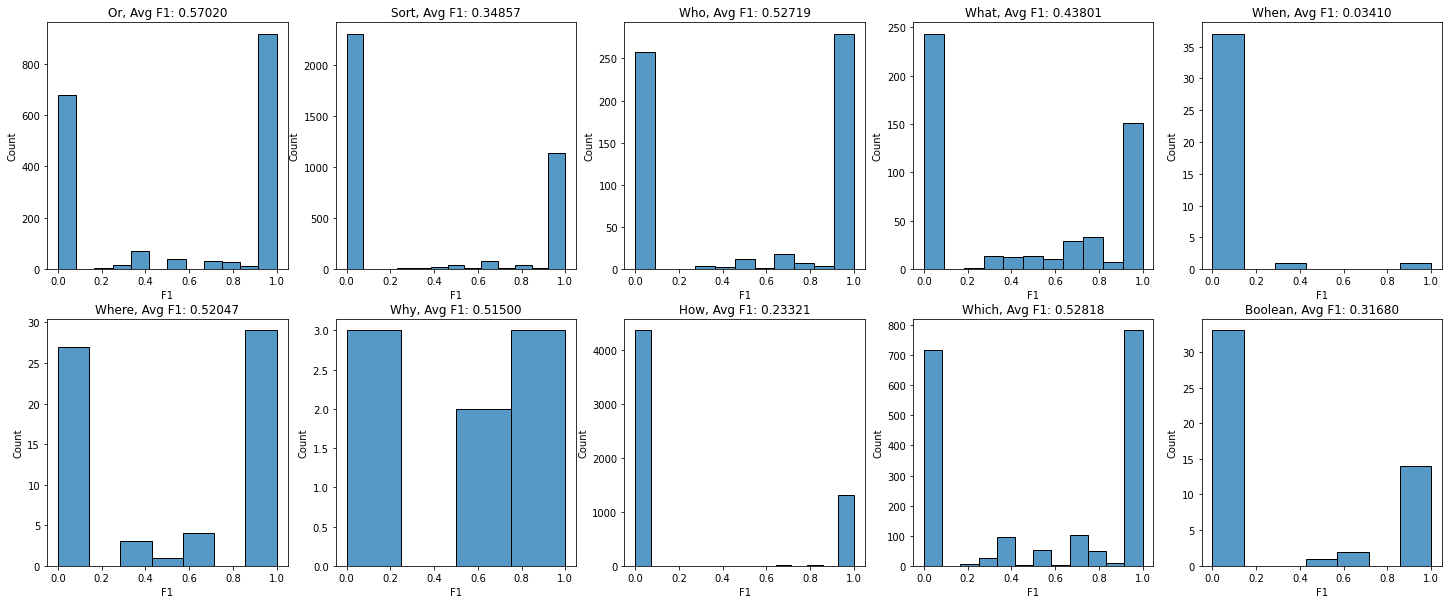

In [12]:
nrows = 2
ncols = 5
counter = 0
fig,ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=(25,10))
for row in range(nrows):
    for col in range(ncols):
        ax[row,col] = sns.histplot(data=df[df[qTypes[counter]]==1],x='F1',label=qTypes[counter],ax=ax[row,col])
        ax[row,col].set_title(f'{qTypes[counter]}, Avg F1: {df[df[qTypes[counter]] == 1].F1.mean():0.5f}')
        counter += 1
    